In [1]:
import numpy as np
import pandas as pd
import do_mpc
from Data_Cleaner import data_loader_main
from SINDy import SINDy_Dynamics
from MPC_Controller import Flow_Dynamics_Model, MPC_Controller
from utilis import MPC_params, setup_mpc

/opt/anaconda3/envs/SUMO_Project/lib/python3.10/site-packages/do_mpc/sysid/__init__.py:15: UserWarning: The ONNX feature is not available. Please install the full version of do-mpc to access this feature.
  warnings.warn('The ONNX feature is not available. Please install the full version of do-mpc to access this feature.')
/opt/anaconda3/envs/SUMO_Project/lib/python3.10/site-packages/do_mpc/opcua/__init__.py:14: UserWarning: The opcua feature is not available. Please install the full version of do-mpc to access this feature.
  warnings.warn('The opcua feature is not available. Please install the full version of do-mpc to access this feature.')


In [2]:
flow_all, _, occupancy_all, flow_dt, _, occupancy_dt = data_loader_main(csv_dict='Sim_Results/Ramp_ALIANA')

# import ramp metering data
control_input = pd.read_csv('Results/Meter_Rate_ALIANA.csv')

# remove the first 5 seconds
flow_all = flow_all.iloc[5:, :].reset_index(drop=True)
flow_dt = flow_dt.iloc[5:, :].reset_index(drop=True)
occupancy_all = occupancy_all.iloc[5:, :].reset_index(drop=True)
occupancy_dt = occupancy_dt.iloc[5:, :].reset_index(drop=True)
control_input = control_input.iloc[5:, :].reset_index(drop=True)

In [3]:
control_input = control_input/10

In [4]:
equations = SINDy_Dynamics(x=occupancy_all, dx=occupancy_dt, u= control_input)

In [5]:
equations

['-0.022751 * x0**2 + 0.070141 * x0 * x1 + 0.008852 * x0 * x4 + -0.018467 * x0 * x5 + 0.010061 * x1**2 + -0.103936 * x1 * x2 + 0.015790 * x1 * x5 + -0.015257 * x1 * x6 + 0.043995 * x2**2 + -0.010529 * x2 * x4 + 0.020535 * x2 * x6',
 '-0.050106 * x0 * x2 + 0.021898 * x0 * x6 + 0.021970 * x1**2 + -0.018499 * x1 * x6 + 0.017876 * x2**2',
 '0.015191 * x0 * x1 + -0.019753 * x0 * x2 + -0.005547 * x1 * x2 + 0.008449 * x2**2',
 '-0.096165 * x0**2 + -0.031143 * x0 * x1 + 0.313682 * x0 * x2 + -0.053692 * x0 * x3 + -0.039281 * x0 * x4 + 0.069197 * x0 * x5 + -0.032339 * x0 * x6 + 0.010445 * x0 * x7 + 0.143019 * x1**2 + -0.387651 * x1 * x2 + 0.010009 * x1 * x3 + 0.029207 * x1 * x5 + 0.021207 * x1 * x6 + -0.019396 * x1 * x7 + 0.055451 * x2**2 + 0.036412 * x2 * x3 + 0.072028 * x2 * x4 + -0.089610 * x2 * x5 + 0.006141 * x2 * x6 + 0.009160 * x2 * x7 + -0.007113 * x3**2 + 0.014392 * x3 * x4 + -0.017073 * x4 * x5',
 '-0.174998 * x0**2 + 0.171623 * x0 * x1 + 0.256764 * x0 * x2 + -0.027921 * x0 * x3 + -0.0

In [6]:
# configure dynamics model
model = Flow_Dynamics_Model(equations)

In [7]:
# configure MPC Contorller
mpc = MPC_Controller(model=model, params=MPC_params, setup_mpc= setup_mpc, silence_solver=False)

In [33]:
mpc.reset_history()

In [34]:
x_0 = np.array(occupancy_all.iloc[0,:])

In [35]:
mpc.x0 = x_0

In [36]:
mpc.set_initial_guess()

In [37]:
x_t = np.array(occupancy_all.iloc[80,:])

In [38]:
u_0 = mpc.make_step(x_t)

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      988
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      628

Total number of variables............................:      232
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      176
                     variables with only upper bounds:        0
Total number of equality constraints.................:      168
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  3.7318000e+02 2.03e+01 1.10e-01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

In [39]:
mpc.opt_x_num['_x', 1]

[[DM([10.6163, 10.7317, 9.16968, 12.2046, 22.7367, 24.4077, 19.3815, 25.2012]),
  DM([10.5156, 10.6321, 9.14902, 12.5847, 23.7995, 24.4233, 21.6831, 18.1065]),
  DM([10.5156, 10.6321, 9.14902, 12.5847, 23.7995, 24.4233, 21.6831, 18.1065]),
  DM([10.5156, 10.6321, 9.14902, 12.5847, 23.7995, 24.4233, 21.6831, 18.1065])]]

In [40]:
np.round(u_0,0) * 10

array([[1790.],
       [1790.],
       [1790.],
       [1790.],
       [1000.],
       [ 220.],
       [ 450.],
       [ 200.]])

In [41]:
import matplotlib.pyplot as plt
import matplotlib as mpl
# Customizing Matplotlib:
mpl.rcParams['font.size'] = 18
mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['axes.grid'] = True

In [42]:
mpc_graphics = do_mpc.graphics.Graphics(mpc.data)
# sim_graphics = do_mpc.graphics.Graphics(simulator.data)

In [43]:
%%capture
fig, ax = plt.subplots(2, sharex=True, figsize=(16,9))
fig.align_ylabels()
for g in [mpc_graphics]:
    # Plot the angle positions (phi_1, phi_2, phi_2) on the first axis:
    g.add_line(var_type='_x', var_name='x0', axis=ax[0])
    g.add_line(var_type='_x', var_name='x1', axis=ax[0])
    g.add_line(var_type='_x', var_name='x2', axis=ax[0])
    g.add_line(var_type='_x', var_name='x3', axis=ax[0])
    g.add_line(var_type='_x', var_name='x4', axis=ax[0])
    g.add_line(var_type='_x', var_name='x5', axis=ax[0])
    g.add_line(var_type='_x', var_name='x6', axis=ax[0])
    g.add_line(var_type='_x', var_name='x7', axis=ax[0])
    

    # Plot the set motor positions (phi_m_1_set, phi_m_2_set) on the second axis:
    g.add_line(var_type='_u', var_name='u0', axis=ax[1])
    g.add_line(var_type='_u', var_name='u1', axis=ax[1])
    g.add_line(var_type='_u', var_name='u2', axis=ax[1])
    g.add_line(var_type='_u', var_name='u3', axis=ax[1])
    g.add_line(var_type='_u', var_name='u4', axis=ax[1])
    g.add_line(var_type='_u', var_name='u5', axis=ax[1])
    g.add_line(var_type='_u', var_name='u6', axis=ax[1])
    g.add_line(var_type='_u', var_name='u7', axis=ax[1])


ax[0].set_ylabel('Flow')
ax[1].set_ylabel('')
ax[1].set_xlabel('time [min]')

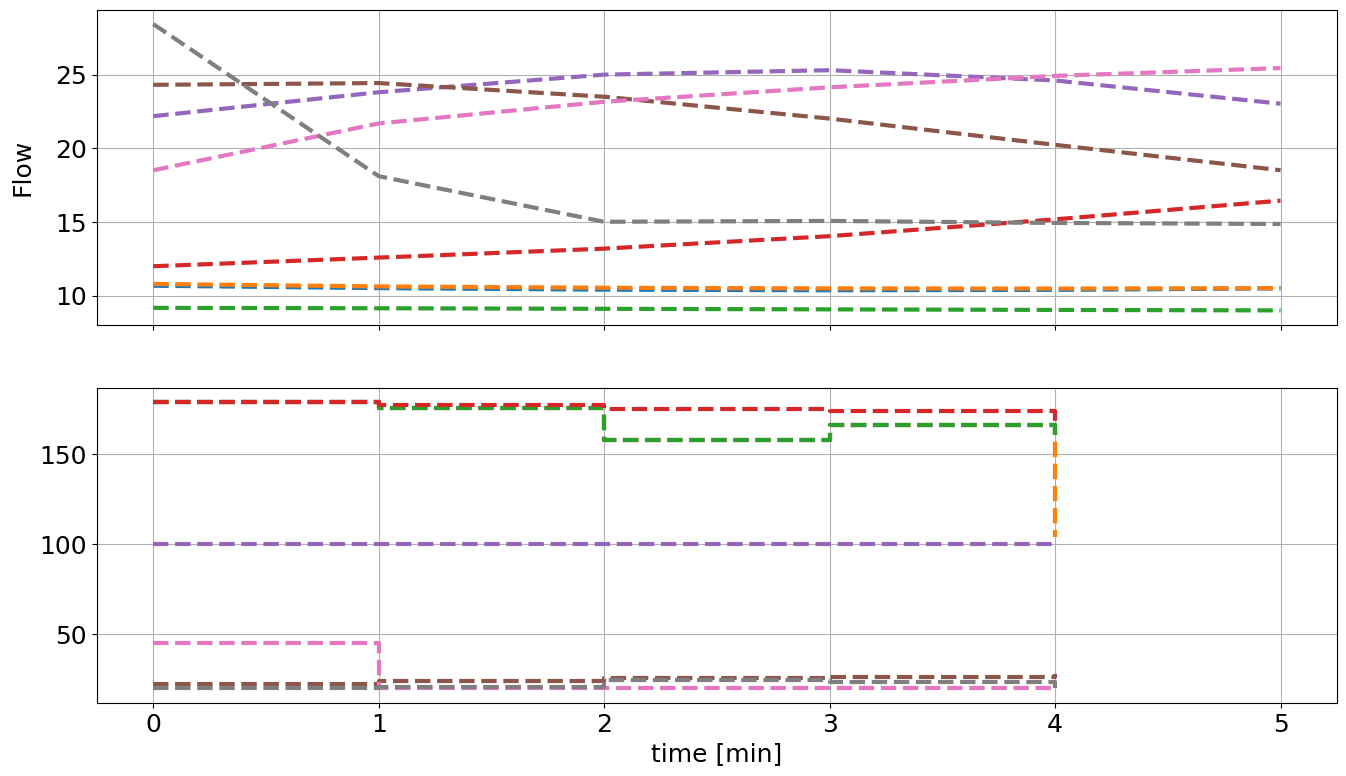

In [44]:
mpc_graphics.plot_predictions()
mpc_graphics.reset_axes()
# Show the figure:
fig